In [4]:
import numpy as np 
import pandas as pd
from sklearn.metrics import zero_one_loss, mean_squared_error
import time
import matplotlib.pyplot as plt
import os
import seaborn as sns 
import matplotlib.pyplot as plt

from scipy.integrate import quad
from numpy import sqrt, sin, cos, pi

%matplotlib qt

In [37]:
#get all required dataset files
tiVsAlgFiles = os.listdir('C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\Algorithm vs TI')
groundTruthFiles = os.listdir('C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\Ground Truth')

In [19]:
#location datasets
#note X1 dataset - (x,y) = (-1.5,2.5)
#X2 dataset - (1.8,4)
#X3 dataset - (1.8,2.5)

### Accuracy

In [105]:
accuracy = np.array([])
for name in tiVsAlgFiles:
    path = 'C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\Algorithm vs TI\\' + name
    tiVsAlgDf = pd.read_csv(path, usecols=['TI', 'Group 16'], dtype=int)
    path = 'C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\Ground Truth\\' + name
    groundTruthDf = pd.read_csv(path, usecols=['Expected Kalman'], dtype=int)
    maxNumberOfPeople = name[0]
    #remove rows with 111 in them (invalid rows)
    mask = np.logical_not(np.equal(groundTruthDf.values, 111))
    groundTruthDf = groundTruthDf[mask]
    tiVsAlgDf = tiVsAlgDf[mask]
    
    #compare the ground truth to TI
    if accuracy.size == 0:
        accuracy = np.array([np.subtract(100,zero_one_loss(groundTruthDf['Expected Kalman'], tiVsAlgDf['TI'])*100),
                             zero_one_loss(groundTruthDf['Expected Kalman'], tiVsAlgDf['TI'], normalize=False),
                             'TI', name,maxNumberOfPeople,groundTruthDf['Expected Kalman'].shape[0]])
        accuracy = np.vstack((accuracy, np.array([np.subtract(100,zero_one_loss(groundTruthDf['Expected Kalman'], tiVsAlgDf['Group 16'])*100), 
                                                  zero_one_loss(groundTruthDf['Expected Kalman'], tiVsAlgDf['Group 16'], normalize=False),
                                                  'Group16',name,maxNumberOfPeople,groundTruthDf['Expected Kalman'].shape[0]])))
    else:
        accuracy = np.vstack((accuracy, np.array([np.subtract(100,zero_one_loss(groundTruthDf['Expected Kalman'], tiVsAlgDf['TI'])*100), 
                                                  zero_one_loss(groundTruthDf['Expected Kalman'], tiVsAlgDf['TI'], normalize=False),
                                                  'TI',name,maxNumberOfPeople,groundTruthDf['Expected Kalman'].shape[0]])))
    
        accuracy = np.vstack((accuracy, np.array([np.subtract(100,zero_one_loss(groundTruthDf['Expected Kalman'], tiVsAlgDf['Group 16'])*100), 
                                                  zero_one_loss(groundTruthDf['Expected Kalman'], tiVsAlgDf['Group 16'], normalize=False),
                                                  'Group16',name,maxNumberOfPeople,groundTruthDf['Expected Kalman'].shape[0]])))

accuracyDf = pd.DataFrame(accuracy)
accuracyDf.columns = ['Accuracy %', 'Misclassifications Amount', 'Group', 'Dataset', 'Number Of People', 'Total Frames']
accuracyDf['Accuracy %'] = accuracyDf['Accuracy %'].astype(dtype=np.float32)

fig, ax = plt.subplots()
fig.set_size_inches(11.8, 8.3)
accuracyDf['Dataset'] = pd.Series([datasetName[:-4]for datasetName in accuracyDf['Dataset']]) #remove .csv from files
accPlot = sns.barplot(y='Dataset', x='Accuracy %', hue='Group', data=accuracyDf,orient='h',hue_order=["Group16", "TI"])
accPlot.set_title('Accuracy % versus Dataset')
accPlot.set_xlabel('Accuracy %')


Text(0.5, 0, 'Accuracy %')

### Accuracy versus Number of People

In [193]:
#run code above first
accuracyDf['Number Of People'] = accuracyDf['Number Of People'].astype(dtype=int)
accuracyDf['Accuracy %'] = accuracyDf['Accuracy %'].astype(dtype=float)
accuracyDf['Total Frames'] = accuracyDf['Total Frames'].astype(dtype=int)
accuracyOverall = np.array([])

for peopleCount in range(1,6):
    mask = np.equal(accuracyDf['Number Of People'],peopleCount)
    requiredFrame = accuracyDf[mask]
    tiMask = np.equal(requiredFrame['Group'], 'TI')
    
    totalFrames = np.sum(requiredFrame[tiMask]['Total Frames'])
    accurayFramesTI = int(np.sum(np.multiply(requiredFrame[tiMask]['Accuracy %']/100,
                                             requiredFrame[tiMask]['Total Frames'])))
    accuracyFramesG16 = int(np.sum(np.multiply(requiredFrame[np.logical_not(tiMask)]['Accuracy %']/100,
                                               requiredFrame[tiMask]['Total Frames'])))
    accuracyTI = (accurayFramesTI/totalFrames) * 100
    accuracyG16 = (accuracyFramesG16/totalFrames) * 100
    
    if accuracyOverall.size == 0:
        accuracyOverall = np.array([peopleCount,accuracyTI, 'TI'])
        accuracyOverall = np.vstack((accuracyOverall,np.array([peopleCount,accuracyG16, 'Group16'])))
    else:
        accuracyOverall = np.vstack((accuracyOverall,np.array([peopleCount,accuracyTI, 'TI'])))
        accuracyOverall = np.vstack((accuracyOverall,np.array([peopleCount,accuracyG16, 'Group16'])))
    
        
accuracyOverallDf = pd.DataFrame(accuracyOverall)
accuracyOverallDf.columns = ['PeopleCount', 'Accuracy', 'Group']

fig, ax = plt.subplots()
fig.set_size_inches(11.8, 8.3)
accuracyOverallDf['Accuracy']=accuracyOverallDf['Accuracy'].astype(dtype=np.float32)
accOverallPlot = sns.barplot(x='PeopleCount',y='Accuracy',hue='Group', data=accuracyOverallDf, hue_order=["Group16", "TI"])
accOverallPlot.set_xlabel('Number of People')
accOverallPlot.set_ylabel('Accuracy %')
accOverallPlot.set_title('Accuracy % versus Number Of People')
#values inside the bars
for p in accOverallPlot.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height-5,
            '{:1.2f}'.format(height),
            ha="center") 

## Overall Accuracy

In [205]:
tiMask = np.equal(accuracyDf['Group'], 'TI')
requiredFrame = accuracyDf[tiMask]
totalFrames = np.sum(requiredFrame['Total Frames'])
totalTIMisclassifications = np.sum(requiredFrame['Misclassifications Amount'].astype(int))
overallTIAccuracy = (1 - (totalTIMisclassifications/totalFrames)) * 100
totalAccuracy = np.array([overallTIAccuracy,'TI'])

Gp16Mask = np.equal(accuracyDf['Group'], 'Group16')
requiredFrame = accuracyDf[Gp16Mask]
totalFrames = np.sum(requiredFrame['Total Frames'])
totalGPMisclassifications = np.sum(requiredFrame['Misclassifications Amount'].astype(int))
overallGPAccuracy = (1 - (totalGPMisclassifications/totalFrames)) * 100

totalAccuracy = np.vstack((totalAccuracy,np.array([overallGPAccuracy,'Group 16'])))
totalAccuracyDf = pd.DataFrame(totalAccuracy, columns=['Accuracy %', 'Group'])
totalAccuracyDf['Accuracy %'] = totalAccuracyDf['Accuracy %'].astype(float)

fig, ax = plt.subplots()
fig.set_size_inches(11.8, 8.3)
accOverallPlot = sns.barplot(x='Group',y='Accuracy %', data=totalAccuracyDf, order=['Group 16', 'TI'])
accOverallPlot.set_xlabel('System')
accOverallPlot.set_ylabel('Accuracy %')
accOverallPlot.set_title('Accuracy % versus System')
#values inside the bars
for p in accOverallPlot.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height-5,
            '{:1.2f}'.format(height),
            ha="center") 

## Location (KF Accuracy Graphs)

In [194]:
xRMSE = np.array([])
yRMSE = np.array([])
for name in tiVsAlgFiles:
    try:
        path = 'C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\Algorithm vs TI\\' + name
        tiVsAlgDf = pd.read_csv(path, usecols=['xTi', 'yTi', 'xGroup16', 'yGroup16'], dtype=np.float32)
        path = 'C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\Ground Truth\\' + name
        groundTruthDf = pd.read_csv(path, usecols=['Expected X', 'Expected Y'], dtype=np.float32)
    except ValueError: #if not a location based dataset
        continue

    
    #remove rows with NaN in them (invalid rows)
    mask = np.logical_and(np.logical_not(np.isnan(tiVsAlgDf['xGroup16'])),np.logical_not(np.isnan(tiVsAlgDf['xTi'])))
    groundTruthDf = groundTruthDf[mask]
    tiVsAlgDf = tiVsAlgDf[mask]
    
    #calculate error in x direction (for both TI and Group16 Algorithm)
    if xRMSE.size == 0:
        rmseAlg = np.sqrt(mean_squared_error(groundTruthDf['Expected X'], tiVsAlgDf['xGroup16']))
        xRMSE = np.array([rmseAlg, 'Group16', name])
        rmseTi = np.sqrt(mean_squared_error(groundTruthDf['Expected X'], tiVsAlgDf['xTi']))
        xRMSE = np.vstack((xRMSE,np.array([rmseTi,'TI',name])))
    else:
        rmseAlg = np.sqrt(mean_squared_error(groundTruthDf['Expected X'], tiVsAlgDf['xGroup16']))
        xRMSE = np.vstack((xRMSE,np.array([rmseAlg, 'Group16',name])))
        rmseTi = np.sqrt(mean_squared_error(groundTruthDf['Expected X'], tiVsAlgDf['xTi']))
        xRMSE = np.vstack((xRMSE,np.array([rmseTi,'TI',name])))
        
    #calculate error in y direction (for both TI and Group16 Algorithm)
    if yRMSE.size == 0:
        rmseAlg = np.sqrt(mean_squared_error(groundTruthDf['Expected Y'], tiVsAlgDf['yGroup16']))
        yRMSE = np.array([rmseAlg, 'Group16', name])
        rmseTi = np.sqrt(mean_squared_error(groundTruthDf['Expected Y'], tiVsAlgDf['yTi']))
        yRMSE = np.vstack((yRMSE,np.array([rmseTi,'TI',name])))
    else:
        rmseAlg = np.sqrt(mean_squared_error(groundTruthDf['Expected Y'], tiVsAlgDf['yGroup16']))
        yRMSE = np.vstack((yRMSE,np.array([rmseAlg, 'Group16',name])))
        rmseTi = np.sqrt(mean_squared_error(groundTruthDf['Expected Y'], tiVsAlgDf['yTi']))
        yRMSE = np.vstack((yRMSE,np.array([rmseTi,'TI',name])))
        
    
rmse = np.hstack((np.expand_dims(yRMSE[:,0], axis=1),xRMSE))
rmseDf = pd.DataFrame(rmse)
rmseDf.columns = ['yRMSE','xRMSE', 'Group', 'Dataset']
rmseDf['xRMSE'] = rmseDf['xRMSE'].astype(dtype=np.float32)
rmseDf['yRMSE'] = rmseDf['yRMSE'].astype(dtype=np.float32)

#plot x y rmse
fig, ax = plt.subplots()
fig.set_size_inches(11.8, 8.3)
xrmsePlot = sns.barplot(x='Dataset', y='xRMSE', hue='Group', data=rmseDf)
xrmsePlot.set_ylabel('Location RMSE - X Direction')
xrmsePlot.set_title('RMSE X direction versus Dataset')

#values inside the bars
for p in xrmsePlot.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height-0.03,
            '{:1.2f}'.format(height),
            ha="center") 

fig, ax = plt.subplots()
fig.set_size_inches(11.8, 8.3)
yrmsePlot = sns.barplot(x='Dataset', y='yRMSE', hue='Group', data=rmseDf)
yrmsePlot.set_ylabel('Location RMSE - Y Direction')
yrmsePlot.set_title('RMSE Y direction versus Dataset')
#values inside the bars
index = 0
for p in yrmsePlot.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height-0.03,
            '{:1.2f}'.format(height),
            ha="center") 
    index += 1
    
    

### Error Types
<html>
    <ul>
        <li> Limitations of the Algorithms </li>
        <li> Sensor Limitations </li>
        <ul>
            <li> Unexplainable missing persons from within the field of view of the sensor </li>
            <li> Occlusions </li>
            <li> Noise from static objects </li> 
        </ul>
    </ul>
</html>


## Parameter Optimization - Clustering

In [120]:
bestParametersClustering = np.array([])
clusterParameterDf = pd.read_csv("C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\Parameter Optimization\\ParameterOptimizationData.csv", usecols=['Index','maxDistance','minClusterSize','Accuracy %'])
#pick min at each maxDistance and at each minClusterSize
for maxDistance in np.unique(clusterParameterDf['maxDistance']):
    mask = clusterParameterDf['maxDistance'] == maxDistance
    minMissclassificationsMask = clusterParameterDf[mask]['Accuracy %']==np.max(clusterParameterDf[mask]['Accuracy %'])
    parameterInfo = np.expand_dims(clusterParameterDf[mask][minMissclassificationsMask].values[0], axis=1)
    if bestParametersClustering.size == 0:
        bestParametersClustering = parameterInfo
    else:
        bestParametersClustering = np.hstack((bestParametersClustering,parameterInfo))

parameterDf = pd.DataFrame(np.transpose(bestParametersClustering), columns=['Old Index','maxDistance', 'minClusterSize', 'Accuracy'])

[(0, 100)]

In [122]:
parameterDf.to_csv("C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\Parameter Optimization\\OptimialParameters.csv")

In [204]:
#clustering scatterplot
parameterDf = pd.read_csv("C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\Parameter Optimization\\OptimialParameters.csv")
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
parameterSetPlot = sns.scatterplot(x='maxDistance', y='minClusterSize', data=parameterDf,ax=ax1)
parameterSetPlot.set(xlim = (0,1.6))
parameterSetPlot.set(ylim = (0,21))
maxDistPlot = sns.scatterplot(x='maxDistance', y='Accuracy', data=parameterDf,ax=ax2)
maxDistPlot.set(xlim = (0,1.6))
maxDistPlot.set(ylim = (0,100))
minClusterPlot = sns.scatterplot(x='minClusterSize', y='Accuracy',data=parameterDf,ax=ax3)
minClusterPlot.set(xlim = (0,21))
minClusterPlot.set(ylim = (0,100))

[(0, 100)]

## Q R Graph 

### Baseline

In [196]:
#measured measured x vs predicted x 
#want to see predicted is smooth vs measured is jaggy 

#load dataset
path = 'C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\QR\\baselineQR.csv'
qrDfBaseline = pd.read_csv(path, usecols=['x16', 'y16', 'measuredX', 'measuredY'], dtype=np.float32)

#restructure qrDf into X and Y
xLabel = np.repeat('Filtered', repeats=qrDfBaseline.shape[0])
xLabel = np.append(xLabel, np.repeat('Measured', repeats=qrDfBaseline.shape[0]))
xInformation = np.append(qrDfBaseline['x16'], qrDfBaseline['measuredX'])
instance = np.append(np.arange(0,qrDfBaseline.shape[0]),np.arange(0,qrDfBaseline.shape[0]))
qrXDf = pd.DataFrame(np.transpose(np.array([xInformation,xLabel,instance])), columns=['xData', 'xLabel', 'instance'])

yLabel = np.repeat('Filtered', repeats=qrDfBaseline.shape[0])
yLabel = np.append(yLabel, np.repeat('Measured', repeats=qrDfBaseline.shape[0]))
yInformation = np.append(qrDfBaseline['y16'], qrDfBaseline['measuredY'])
instance = np.append(np.arange(0,qrDfBaseline.shape[0]),np.arange(0,qrDfBaseline.shape[0]))
qrYDf = pd.DataFrame(np.transpose(np.array([yInformation,yLabel,instance])), columns=['yData', 'yLabel', 'instance'])

In [197]:
#baseline X
qrXDf['xData'] = qrXDf['xData'].astype(np.float32)
qrXDf['instance'] = qrXDf['instance'].astype(np.int)
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.lineplot(x="instance", y="xData",hue="xLabel", data=qrXDf)

In [198]:
#baseline Y
qrYDf['yData'] = qrYDf['yData'].astype(np.float32)
qrYDf['instance'] = qrYDf['instance'].astype(np.int)
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.lineplot(x="instance", y="yData",hue="yLabel", data=qrYDf)

### Modified QR

In [26]:
#measured measured x vs predicted x 
#want to see predicted is smooth vs measured is jaggy 

#load dataset
path = 'C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\QR\\modifedQR1.csv'
qrDfBaseline = pd.read_csv(path, usecols=['x16', 'y16', 'measuredX', 'measuredY'], dtype=np.float32)

#restructure qrDf into X and Y
xLabel = np.repeat('Filtered', repeats=qrDfBaseline.shape[0])
xLabel = np.append(xLabel, np.repeat('Measured', repeats=qrDfBaseline.shape[0]))
xInformation = np.append(qrDfBaseline['x16'], qrDfBaseline['measuredX'])
instance = np.append(np.arange(0,qrDfBaseline.shape[0]),np.arange(0,qrDfBaseline.shape[0]))
qrXDf = pd.DataFrame(np.transpose(np.array([xInformation,xLabel,instance])), columns=['xData', 'xLabel', 'instance'])

yLabel = np.repeat('Filtered', repeats=qrDfBaseline.shape[0])
yLabel = np.append(yLabel, np.repeat('Measured', repeats=qrDfBaseline.shape[0]))
yInformation = np.append(qrDfBaseline['y16'], qrDfBaseline['measuredY'])
instance = np.append(np.arange(0,qrDfBaseline.shape[0]),np.arange(0,qrDfBaseline.shape[0]))
qrYDf = pd.DataFrame(np.transpose(np.array([yInformation,yLabel,instance])), columns=['yData', 'yLabel', 'instance'])

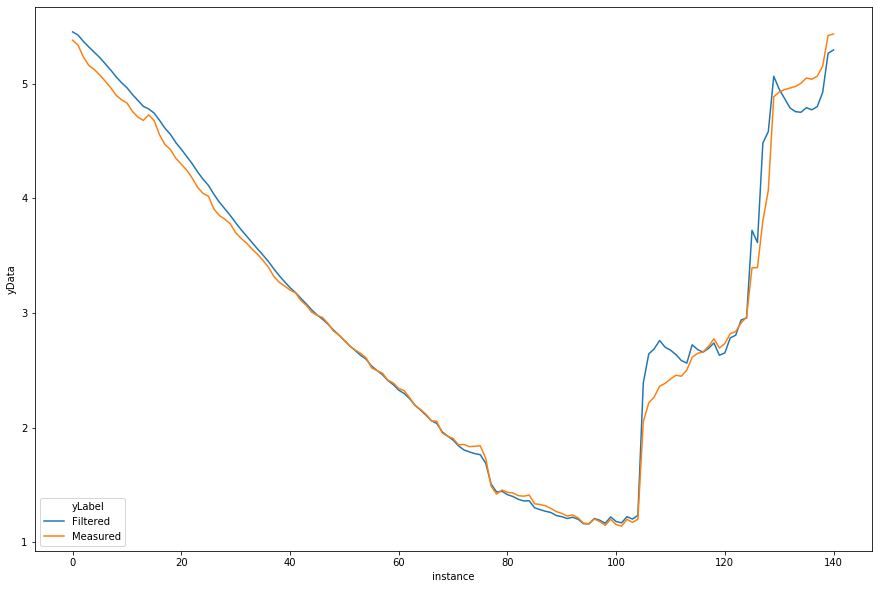

In [27]:
#Y
qrYDf['yData'] = qrYDf['yData'].astype(np.float32)
qrYDf['instance'] = qrYDf['instance'].astype(np.int)
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.lineplot(x="instance", y="yData",hue="yLabel", data=qrYDf)

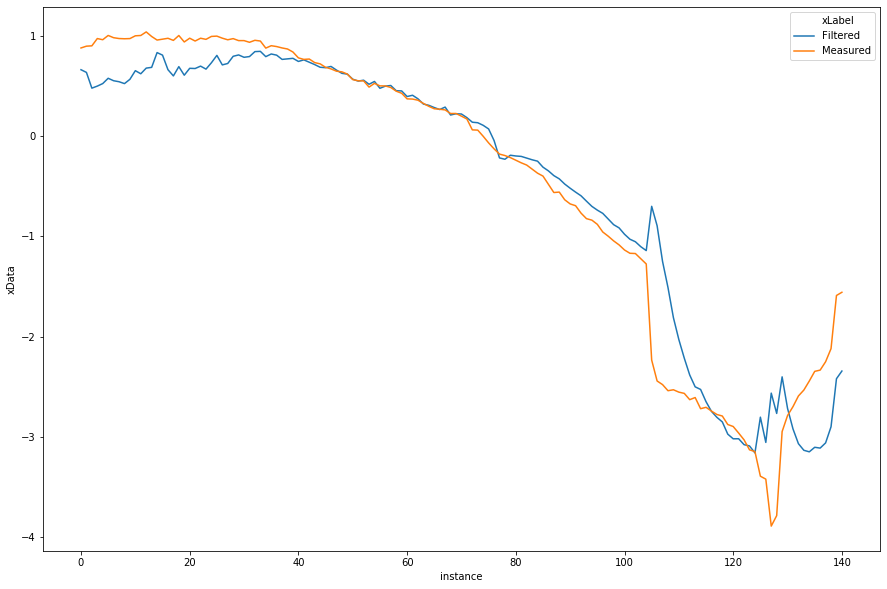

In [28]:
#X
qrXDf['xData'] = qrXDf['xData'].astype(np.float32)
qrXDf['instance'] = qrXDf['instance'].astype(np.int)
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.lineplot(x="instance", y="xData",hue="xLabel", data=qrXDf)

## Heatmap of Error

In [14]:
#voxel splitting
#sensorRange
def integrand(x, a, b):
    return -a*b*sin(x)*sin(x)

a = 6
b = 5
areaSensorRange = np.abs(quad(integrand, (40/180)*pi, (140/180)*pi, args=(a,b))[0])
equivalentRecX = 9
equivalentRecY = 6
heatmapData = np.random.rand(equivalentRecX,equivalentRecY)

a = 1
b = 1
areaVoxel = a*b

numberOfVoxels = round(areaSensorRange/areaVoxel)

fig, (ax1,ax2) = plt.subplots(2)
fig.set_size_inches(20, 20)

#load voxel
path = 'C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\Heatmap\\Voxel Data.csv'
voxelDf = pd.read_csv(path)
voxelData = np.reshape(voxelDf['% Conditional Accuracy'].values, (equivalentRecY,equivalentRecX))
voxelData = np.flip(voxelData,axis=0) #flip to get right orientation
heat_map = sns.heatmap(voxelData,square=False,annot=False,xticklabels=[], yticklabels=[] ,ax=ax1,cmap="YlGnBu",vmin=50, vmax=100)

## Sensor Range Map

In [15]:
maxAz = 140
minAz = 40

rangeSteps = np.arange(1,6.05, step=0.05)
azSteps = np.arange((minAz/180)*pi,(maxAz/180)*pi + (1/180)*pi, step=(1/180)*pi)

#sides
SidesX = np.multiply(rangeSteps,cos((maxAz/180)*pi))
SidesX = np.append(SidesX,np.multiply(rangeSteps,cos((minAz/180)*pi)))
SidesY = np.multiply(rangeSteps,sin((maxAz/180)*pi))
SidesY = np.append(SidesY,np.multiply(rangeSteps,sin((minAz/180)*pi)))

#top edge
topX = np.multiply(6,cos(azSteps))
topY = np.multiply(6,sin(azSteps))

sideDf = pd.DataFrame(np.transpose(np.array([SidesX, SidesY])), columns = ['X', 'Y'])
sensorPlot = sns.lineplot(x="X", y="Y",data=sideDf,color="#34495e")

topDf = pd.DataFrame(np.transpose(np.array([topX, topY])), columns = ['X', 'Y'])
sensorPlot = sns.lineplot(x="X", y="Y",data=topDf,color="#34495e",ax=ax2)
#save figure
fig.savefig('plot.svg')

### Live Demo Timing Analysis

In [218]:
#1000 iterations over all datasets finding average numbers for each dataset (1 to 5 people)

#import timing data
timingDf = pd.read_csv("C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\Timing Analysis\\Timing Data.csv",
                      usecols=['Number Of People', 'Iteration','Runtime'])

timingData = np.array([])
#average runtime per number of People
for numberOfPeople in range(1,6):
    mask = timingDf['Number Of People'] == numberOfPeople
    subsetTimingDf = timingDf[mask]
    averageTiming = np.mean(timingDf[mask]['Runtime'])
    if timingData.size == 0:
        timingData = np.array([numberOfPeople,averageTiming])
    else:
        timingData = np.vstack((timingData,np.array([numberOfPeople,averageTiming])))

averageTimeDf = pd.DataFrame(timingData, columns=['Number Of People', 'Average Time (ms)'])
averageTimeDf['Number Of People'] = averageTimeDf['Number Of People'].astype(int)
averagePlot = sns.barplot(x='Number Of People',y='Average Time (ms)', data=averageTimeDf)

for p in averagePlot.patches:
    height = p.get_height()
    averagePlot.text(p.get_x()+p.get_width()/2.,
            height-2,
            '{:1.2f}'.format(height),
            ha="center") 

Rectangle(xy=(-0.4, 0), width=0.8, height=5.139, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=9.683, angle=0)
Rectangle(xy=(1.6, 0), width=0.8, height=14.652, angle=0)
Rectangle(xy=(2.6, 0), width=0.8, height=30.257, angle=0)
Rectangle(xy=(3.6, 0), width=0.8, height=34.916, angle=0)


### Performance Gains

In [209]:
performanceDf = pd.read_csv("C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\Timing Analysis\\NoiseRemovalPerformanceGains.csv",
                      usecols=['Number Of People', 'Iteration','Runtime', 'With/Without'])

In [220]:
#calculate average 
timingData = np.array([])
#average runtime per number of People
timingDf = performanceDf[performanceDf['With/Without'] == 'With Preliminary Noise Reduction']
for numberOfPeople in range(1,6):
    mask = timingDf['Number Of People'] == numberOfPeople
    subsetTimingDf = timingDf[mask]
    averageTiming = np.mean(timingDf[mask]['Runtime'])
    if timingData.size == 0:
        timingData = np.array([numberOfPeople,averageTiming, 'With'])
    else:
        timingData = np.vstack((timingData,np.array([numberOfPeople,averageTiming, 'With'])))

timingDf = performanceDf[performanceDf['With/Without'] == 'Without Preliminary Noise Reduction']
for numberOfPeople in range(1,6):
    mask = timingDf['Number Of People'] == numberOfPeople
    subsetTimingDf = timingDf[mask]
    averageTiming = np.mean(timingDf[mask]['Runtime'])
    if timingData.size == 0:
        timingData = np.array([numberOfPeople,averageTiming, 'Without'])
    else:
        timingData = np.vstack((timingData,np.array([numberOfPeople,averageTiming, 'Without'])))

averageTimeDf = pd.DataFrame(timingData, columns=['Number Of People', 'Average Time (ms)', 'With/Without'])
averageTimeDf['Number Of People'] = averageTimeDf['Number Of People'].astype(int)
averageTimeDf['Average Time (ms)'] = averageTimeDf['Average Time (ms)'].astype(float)
noisePlot = sns.barplot(x='Number Of People',y='Average Time (ms)', hue='With/Without',data=averageTimeDf)
noisePlot.set_title('With and Without Preliminary Noise Removal')

for p in noisePlot.patches:
    height = p.get_height()
    noisePlot.text(p.get_x()+p.get_width()/2.,
            height-2,
            '{:1.2f}'.format(height),
            ha="center") 